In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50, VGG19, EfficientNetB7, VGG16

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

<h1> Initialising Data Structure and Inspecting the data </h1>

In [3]:
base_dir = "." 
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


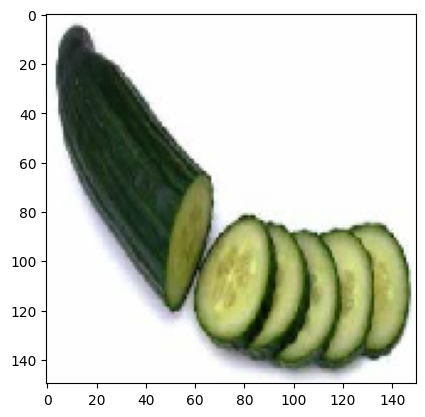

In [4]:
train_cucumber_dir = os.path.join(train_dir, "cucumber")
filenames = [os.path.join(train_cucumber_dir, filename) for filename in os.listdir(train_cucumber_dir)]

idx = 12
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)

<h1> Data Preprocessing </h1>

- Decoding JPEG/JPGS to uncompressed grids of RGB integer values (0,255)
- Resizing the images
- encoding class labels

In [38]:
# using categorical label mode as there is 3 classes
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="categorical", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="categorical", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="categorical", image_size=(224, 224))

Found 150 files belonging to 3 classes.
Found 75 files belonging to 3 classes.
Found 75 files belonging to 3 classes.


In [6]:
# Using Softmax as the activation function and categorical cross entropy for loss
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
convnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                         

<h1>Training and Testing</h1>

In [8]:
convnet_history = convnet.fit(train_dataset, epochs=30, 
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
                verbose=1)

Epoch 1/30
5/5 [==============================] - 12s 2s/step - loss: 1.1245 - accuracy: 0.3933 - val_loss: 1.0550 - val_accuracy: 0.4133
Epoch 2/30
5/5 [==============================] - 11s 2s/step - loss: 0.9974 - accuracy: 0.5400 - val_loss: 0.9115 - val_accuracy: 0.5467
Epoch 3/30
5/5 [==============================] - 13s 3s/step - loss: 0.8746 - accuracy: 0.5667 - val_loss: 0.9114 - val_accuracy: 0.5467
Epoch 4/30
5/5 [==============================] - 13s 3s/step - loss: 0.7318 - accuracy: 0.6333 - val_loss: 0.7320 - val_accuracy: 0.6400
Epoch 5/30
5/5 [==============================] - 13s 3s/step - loss: 0.6973 - accuracy: 0.6600 - val_loss: 0.7058 - val_accuracy: 0.5867
Epoch 6/30
5/5 [==============================] - 13s 3s/step - loss: 0.6012 - accuracy: 0.6933 - val_loss: 0.6697 - val_accuracy: 0.6000
Epoch 7/30
5/5 [==============================] - 13s 3s/step - loss: 0.5952 - accuracy: 0.6800 - val_loss: 0.6855 - val_accuracy: 0.6400
Epoch 8/30
5/5 [==================

<AxesSubplot: >

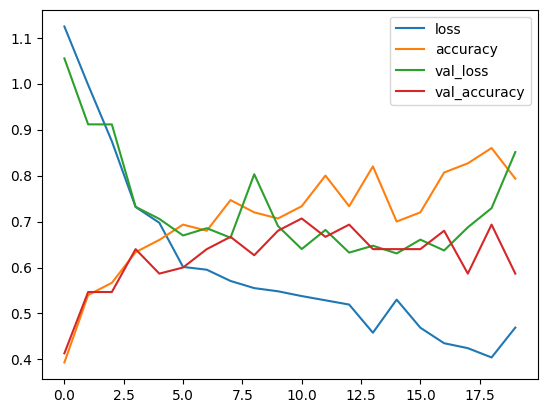

In [9]:
pd.DataFrame(convnet_history.history).plot()

# Model has high loss and accuracy isn't high
# Augment the data to reduce overfitting

<h1>Data Augmentation</h1>

In [10]:
#Augmenting data in the training set to increase the number of training samples
augmentation_layers = Sequential([
    Input(shape=(224, 224, 3)),
    RandomFlip(mode="horizontal"),
    RandomRotation(factor=0.1),
    RandomZoom(height_factor=(-0.2, 0.2)),
    RandomTranslation(height_factor=0.2, width_factor=0.2)
])

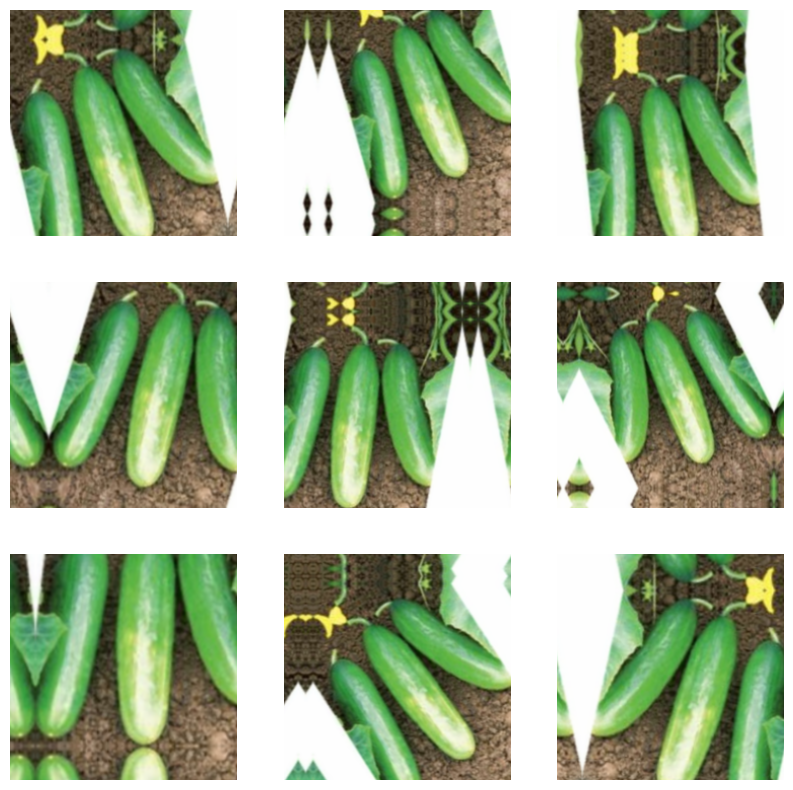

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = augmentation_layers(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
x = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
x = Rescaling(scale=1./255)(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
augmented_model = Model(inputs, outputs)
augmented_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
augmented_model_history = augmented_model.fit(train_dataset, epochs=60, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=1)

Epoch 1/60
5/5 [==============================] - 16s 3s/step - loss: 1.0851 - accuracy: 0.4000 - val_loss: 1.0662 - val_accuracy: 0.3867
Epoch 2/60
5/5 [==============================] - 13s 3s/step - loss: 1.0559 - accuracy: 0.4133 - val_loss: 0.9547 - val_accuracy: 0.5867
Epoch 3/60
5/5 [==============================] - 13s 3s/step - loss: 0.8788 - accuracy: 0.6333 - val_loss: 0.8463 - val_accuracy: 0.5333
Epoch 4/60
5/5 [==============================] - 13s 3s/step - loss: 0.7382 - accuracy: 0.5933 - val_loss: 0.8842 - val_accuracy: 0.5333
Epoch 5/60
5/5 [==============================] - 12s 2s/step - loss: 0.7290 - accuracy: 0.5800 - val_loss: 0.6790 - val_accuracy: 0.6533
Epoch 6/60
5/5 [==============================] - 12s 2s/step - loss: 0.6281 - accuracy: 0.7067 - val_loss: 0.6893 - val_accuracy: 0.6400
Epoch 7/60
5/5 [==============================] - 12s 2s/step - loss: 0.6405 - accuracy: 0.6800 - val_loss: 0.6987 - val_accuracy: 0.6133
Epoch 8/60
5/5 [==================

<AxesSubplot: >

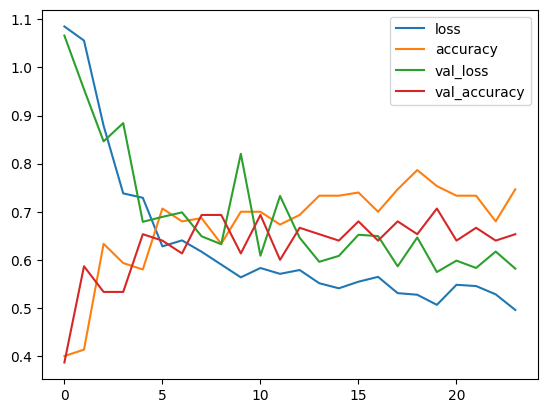

In [14]:
# resulted in similar results to original convnet
pd.DataFrame(augmented_model_history.history).plot()

<h1> Pretrained Convolutional Neural Networks </h1>

<h2> ResNet50 </h2>
<p>
    This performed better than VGG19. It has more consistent higher accuracy and lower loss. 
</p>

In [15]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [16]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

<p>Freezing the weights of the convolutional base to train the upper layers </p>

<p>I also added 2 more layers to this model, which increased the accuracy as it allows the model to extract more features out of the images </p>

In [17]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet50_base(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
transfer_model_resnet = Model(inputs=inputs, outputs=outputs)
resnet50_base.trainable = False

In [18]:
transfer_model_resnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 128)         2359424   
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 3, 32)          36896     
                                                           

In [19]:
transfer_model_resnet.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
transfer_model_resnet_history = transfer_model_resnet.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=1)

Epoch 1/30
5/5 [==============================] - 11s 2s/step - loss: 3.4708 - accuracy: 0.4600 - val_loss: 0.6882 - val_accuracy: 0.6533
Epoch 2/30
5/5 [==============================] - 8s 2s/step - loss: 0.5354 - accuracy: 0.7533 - val_loss: 0.6152 - val_accuracy: 0.6800
Epoch 3/30
5/5 [==============================] - 8s 2s/step - loss: 0.7207 - accuracy: 0.7267 - val_loss: 0.5229 - val_accuracy: 0.7333
Epoch 4/30
5/5 [==============================] - 8s 2s/step - loss: 0.7715 - accuracy: 0.7467 - val_loss: 0.3405 - val_accuracy: 0.8667
Epoch 5/30
5/5 [==============================] - 8s 2s/step - loss: 0.3966 - accuracy: 0.8600 - val_loss: 0.2501 - val_accuracy: 0.8800
Epoch 6/30
5/5 [==============================] - 8s 2s/step - loss: 0.3506 - accuracy: 0.8933 - val_loss: 0.1560 - val_accuracy: 0.9600
Epoch 7/30
5/5 [==============================] - 8s 2s/step - loss: 0.2116 - accuracy: 0.8867 - val_loss: 0.1057 - val_accuracy: 0.9467
Epoch 8/30
5/5 [========================

<AxesSubplot: >

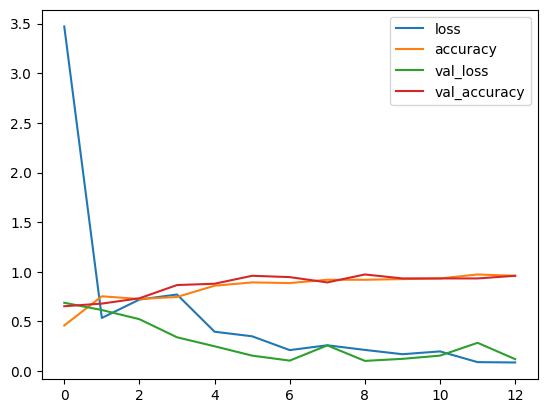

In [21]:
pd.DataFrame(transfer_model_resnet_history.history).plot()

<p> With a lower learning rate selected, I am retraining the whole model for tuning. </p>

<p> The results of the accuracy is already 1 and the loss values are really low, so I think it is unnecessary to tune each layer </p>

In [22]:
for layer in resnet50_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [23]:
transfer_model_resnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


transfer_model_resnet_history = transfer_model_resnet.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<AxesSubplot: >

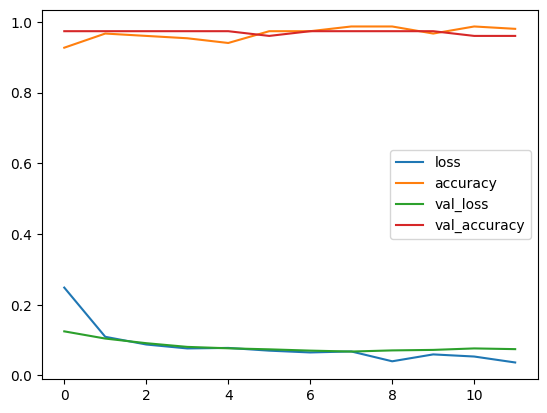

In [24]:
pd.DataFrame(transfer_model_resnet_history.history).plot()

<h2> Analysis of ResNet50 </h2>
<p>
Looking at the results, the model seems to have very high accuracy and low loss values. It also performed better than VGG16/VGG19 for this task. This model is well fitted
</p>

<h1>VGG16/19</h1>
<p>At first VGG16 gave me high loss and low accuracy which made me use VGG19 for a deeper network that may be more suitable for classifying these images</p>

<p>By doing so, it resulted in much lower loss and high accuracy</p>

<p>Although this improved the accuracy, it still performed worse than ResNet50, due to the val_accuracy being lower. For this assingment, I am sticking to using ResNet50 for my transfer model and will comment out code for using vgg19 as it affects my runtime</p>

In [25]:
# vgg19_base = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

<p>Freezing the weights of the convolutional base to train the upper layers </p>

In [26]:
# inputs = Input(shape=(224, 224, 3))
# x = preprocess_input(inputs)
# x = vgg19_base(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# outputs = Dense(3, activation="softmax")(x)
# transfer_model_vgg19 = Model(inputs=inputs, outputs=outputs)
# vgg19_base.trainable = False


In [27]:
# transfer_model_vgg19.summary()

<p> With a lower learning rate selected, I am retraining the whole model for tuning. </p>

In [28]:
# transfer_model_vgg19.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
# transfer_model_vgg19_history = transfer_model_vgg19.fit(train_dataset, epochs=30, 
#                 validation_data=val_dataset, 
#                 callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
#                 verbose=1)

In [30]:
# pd.DataFrame(transfer_model_vgg19_history.history).plot()

In [31]:
# for layer in vgg19_base.layers:
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = False
#     else:
#         layer.trainable = True

In [32]:
# transfer_model_vgg19.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
# transfer_model_vgg19_history = transfer_model.fit(train_dataset, epochs=30, 
#                 validation_data=val_dataset, 
#                 callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
#                 verbose=0)

In [34]:
# pd.DataFrame(transfer_model_vgg19_history.history).plot()

<h2> Testing models </h2>

In [39]:
# The original convnet
test_loss, test_acc = convnet.evaluate(test_dataset)
test_acc

3/3 [==============================] - 1s 334ms/step - loss: 0.5326 - accuracy: 0.6667


0.6666666865348816

In [40]:
# The convnet with dropout, trained using data augmentation
test_loss, test_acc = augmented_model.evaluate(test_dataset)
test_acc

3/3 [==============================] - 1s 329ms/step - loss: 0.5157 - accuracy: 0.6667


0.6666666865348816

In [41]:
# The convnet that was trained and tuned using transfer learning
test_loss, test_acc = transfer_model_resnet.evaluate(test_dataset)
test_acc

3/3 [==============================] - 3s 689ms/step - loss: 0.1077 - accuracy: 0.9467


0.9466666579246521

<h2> Other Remarks </h2>

<p> The current best image classifiers make use of transformers. If I was to try and do this again I would possibly combine my own convolutional neural net and transformers. Unfortunately I lack knowledge of transformers and couldn't implement code at this moment. </p>

<p> Also it seems like the best way to get the best performing image classifiers is to use multiple convolutional bases and use them together to build a model </p>

<h2> Saving the model </h2>

In [ ]:
transfer_model_resnet.save("best_network.h5")